# TP1 — S’orienter par rapport à une référence (panorama équirectangulaire) : retrouver son cap

**Objectif**
Apprendre à estimer une **orientation relative** entre une image de référence et une image courante en utilisant une **rIDF** (*rotational Image Difference Function*) sur des panoramas **équirectangulaires**.
La rIDF utilisée est la **nRMSE** (*normalized root mean square error*, « erreur quadratique moyenne normalisée »).

**Plan du notebook**

1. **Importer & visualiser** le *jeu de données A*.
2. **Calculer la familiarité** (nRMSE) entre une image et **la même** image tournée de 90°.
3. **Calculer et tracer** la **rIDF complète** de deux images, puis **discuter** des différences observées.
4. **Trouver et afficher l’argmin** de la rIDF ; montrer l’importance de l’**amplitude** et du **pas d’échantillonnage angulaire**.
5. **Tester et analyser différents prétraitements** (rééchantillonnage/downsampling, normalisation, Sobel) en comparant les rIDF.

## 0) Setup

> Pour travailler sur les images, on peut utiliser la bibliothèque **Python** *Pillow* (**PIL**) (plus tard, on utilisera **OpenCV**).


In [1]:
COLAB = True ## Set True or false if you are in collab or in local (for the datas)

if COLAB:
    # === Téléchargement & extraction des données dans ./data ===========================
    from pathlib import Path
    import urllib.request, zipfile, tarfile, io, os

    # Indiquez le lien direct du dataset ; .zip / .tar.gz recommandés
    DATA_URL = "https://filesender.renater.fr/download.php?token=ffab855e-64b5-4741-8519-51337987420d&files_ids=61990814"  # <-- REMPLACEZ-MOI (lien de données)
    DATA_DIR = Path("../data")
    DATA_DIR.mkdir(exist_ok=True)

    def download(url: str) -> bytes:
        print(f"Téléchargement depuis {url} …")
        with urllib.request.urlopen(url) as r:
            return r.read()

    blob = download(DATA_URL)

    # Détection simple des formats courants, sinon écriture binaire brute
    with zipfile.ZipFile(io.BytesIO(blob)) as zf:
        zf.extractall(DATA_DIR)

    # Aperçu du contenu
    print("Aperçu:", [p.name for p in DATA_DIR.glob('*')][:10])


Téléchargement depuis https://filesender.renater.fr/download.php?token=ffab855e-64b5-4741-8519-51337987420d&files_ids=61990814 …
Aperçu: ['dataset_B', 'dataset_C', 'dataset_A']


In [2]:
DATASET_DIR = "../data/dataset_A"   # <-- à adapter si necessaire

import os, glob, math, time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.dpi'] = 110


## 1) Utilitaires

> Les fonctions `read_img` et `to_gray` sont fournies.

In [13]:
## Fonctions utiles
def read_img(path):
    im = Image.open(path).convert("RGB")
    arr = np.asarray(im)
    arr = arr.astype(np.float32) / 255.0
    return arr

def to_gray(img):
    return (0.2989*img[...,0] + 0.5870*img[...,1] + 0.1140*img[...,2]).astype(np.float32)

## 2) Import & visualisation du **jeu de données A**

### TODO

* [x] **Compléter** la fonction `plot_image_dataset(paths)`


Trouvé: 2 images dans Dataset A


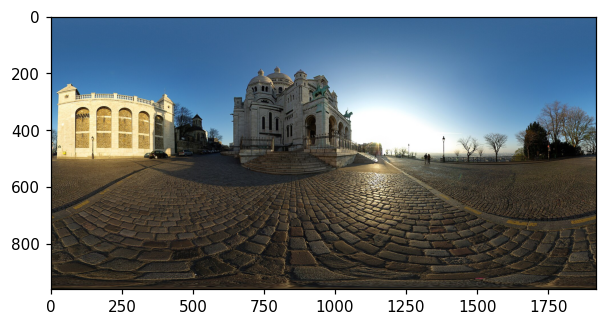

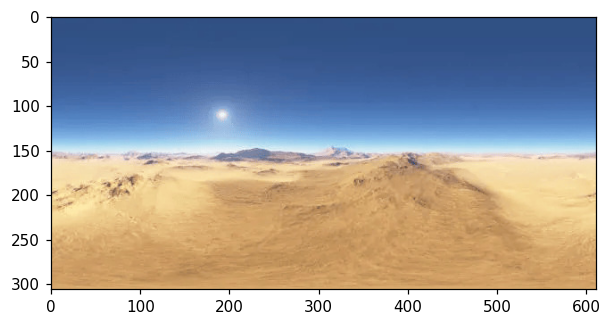

In [14]:
def plot_image_dataset(paths):
    # TODO : Plots the images from the dataset with matplotlib subplot
    for path in ref_paths :
      plt.figure()
      img = plt.imread(path)
      plt.imshow(img)
      plt.show()


## Search for images in the dataset
ref_paths  = sorted(glob.glob(f"{DATASET_DIR}/*.jpg") + glob.glob(f"{DATASET_DIR}/*.png"))
print(f"Trouvé: {len(ref_paths)} images dans Dataset A")

## Appel de la fonction plot
plot_image_dataset(ref_paths)

## 3) Calcul de la familiarité avec la *normalized r.m.s. pixel difference* (nRMSE)

### TODO

* [ ] **Compléter** la fonction qui effectue un décalage de pixels en fonction d’un angle donné : `shift_equirect(img, theta_rad)`.
* [ ] **Compléter** la fonction qui calcule la nRMSE entre deux images : `nrmse(a, b)`.
* [ ] Calculer la familiarité d’une image de la base de **données** par rapport à **la même image** tournée de **90°**, **tracer** les deux images et **afficher** la valeur de familiarité.


nRMSE(ref, rotate+90°) = 0.7928


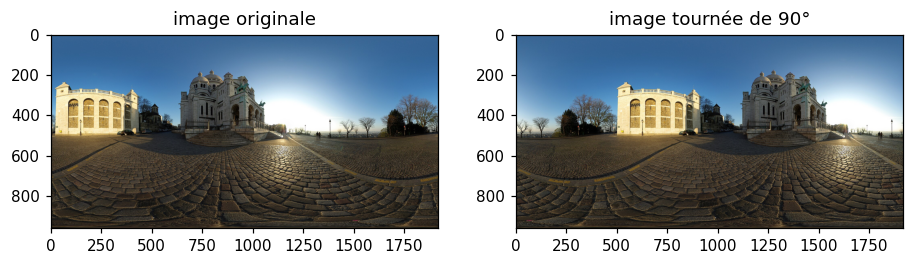

In [27]:
def shift_equirect(img, theta_rad):
    w = img.shape[1]
    k = w * theta_rad / (2 * np.pi)
    img_shifted = np.roll(img, int(k), axis=1)
    return img_shifted


def nrmse(a, b):
    # TODO : Compute the nrmse between two image. The output has to be between 0 and 1 (careful at the data type)
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    diff = a - b
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    familiarity = rmse / np.mean(a)
    return float(familiarity)

ref_rgb = read_img(ref_paths[0])
ref_rot90 = shift_equirect(ref_rgb, np.pi/2)

# TODO : Call the functions
familiarity = nrmse(ref_rgb, ref_rot90)
print(f"nRMSE(ref, rotate+90°) = {familiarity:.4f}")

# TODO : Show the ref image and the rotated image with the familiarity
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1,2, 1)
plt.title("image originale")
plt.imshow(ref_rgb)
plt.subplot(1,2, 2)
plt.title("image tournée de 90°")
plt.imshow(ref_rot90)
plt.show()


## 4) Calcul et visualisation des *Rotational Image Difference Functions* (rIDF)

### TODO

* [ ] **Compléter** la fonction `ridf_nrmse(img_ref, img_test, thetas_deg=np.arange(-Amp, Amp+1, Step))` qui **calcule** la rIDF pour une image de **référence** et une image **test**, avec un scan d’**amplitude** `±Amp` et un **pas** `Step`.
* [ ] **Appeler** la fonction avec `img_ref = img_test` et **tracer** la rIDF de **deux images** de la base de **données**, **superposées**. **Comparer** les courbes et **proposer une explication** aux différences observées. Avec `img_ref = img_test`, on analyse la familiarité de l’image de référence dans son espace angulaire.
* [ ] **Analyser** le **temps de calcul** de la rIDF pour chaque image et **proposer des hypothèses** expliquant les différences.


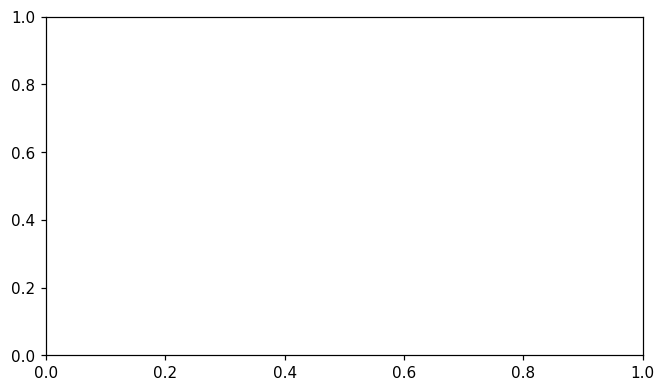

In [28]:
def ridf_nrmse(img_ref, img_test, thetas_deg=np.arange(-180, 181, 1)):
    # TODO : Compute the rIDF with the previous nrms and shift_equirect fonction
    familiarity = []
    for theta_deg in thetas_deg:
        theta_rad = theta_deg * np.pi/180
        img_shifted = shift_equirect(img_test, theta_rad)
        val_nrmse = nrmse(img_ref, img_shifted)
        familiarity.append(val_nrmse)
    return np.array(thetas_deg, dtype=float), np.array(familiarity, dtype=float)

# TODO : Plot the rIDF of the images in the dataset, the scan parameters (Amplitude and Steps are given).
# You can use read_img() and the previous fonction, use time.
THETAS_SCAN = np.arange(-180, 181, 1)
fig, ax = plt.subplots(figsize=(7,4))

## 5) Retrouver son cap : calculer l’argument qui minimise la rIDF

### TODO

* [ ] **Compléter** la fonction `ridf_argmin(rgb, rotation_initiale=0.0, amp_deg=180, step_deg=1)`, qui **prend en entrée** une image de **référence**, un angle de **rotation initiale** appliqué à cette image (pour générer l’image test), ainsi que l’**amplitude** et le **pas** du balayage. Ici, `img_ref != img_test` car l’image **test** sera l’image de référence **tournée** de l’angle désiré. Cette fonction **intégrera les tracés**. On souhaite connaître le **temps de calcul**, le **cap estimé**, le **vrai cap** (initial) et l’**erreur** entre les deux.
* [ ] **Appeler** cette fonction avec un **angle initial de 117°**, une **amplitude de 180°** et un **pas de 1°**.
* [ ] **Appeler** cette fonction avec **différents paramètres** de balayage et **conditions initiales** ; **analyser** et **montrer** les **limites** et les **paramètres importants**.


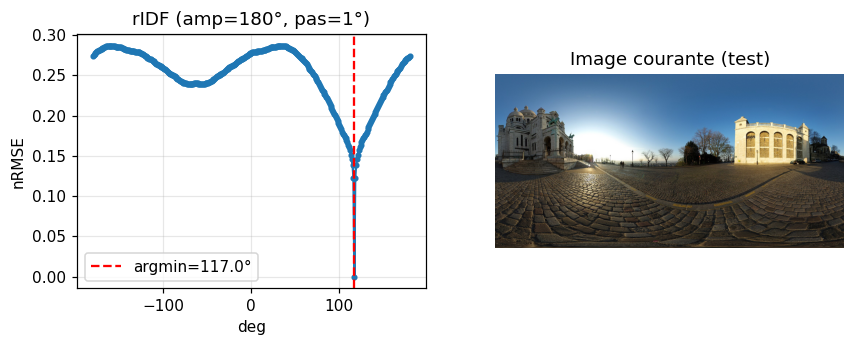

Argmin estimé: 117.0° (vrai: 117.0°)  |  erreur: 0.0°
Temps de calcul: 7.1s


In [ ]:

def ridf_argmin(rgb, rotation_initiale=0.0, amp_deg=180, step_deg=1):
    ti = time.time()
    # TODO : Compute the rIDF between the reference image and the ref img rotated of a certain angle.
    # Find the argmin and print the initial rotation (truth) and the estimated one with familiarity.
    ts = time.time() - ti

    # TODO : Plots the rIDF and show the argmin found with a vertical line. Show also the image tested vs the reference

# TODO : Read the image and call the fonction ridf_argmin() with initial conditions OF 117,180,1.
rgb = read_img(ref_paths[0])


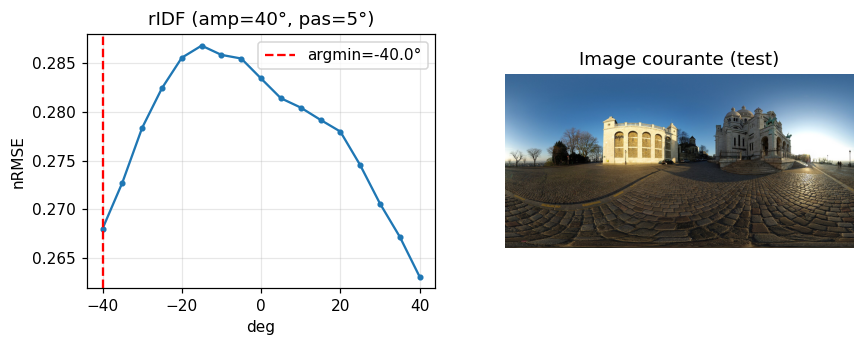

Argmin estimé: -40.0° (vrai: 97.0°)  |  erreur: 137.0°
Temps de calcul: 0.4s


In [ ]:
# TODO : Call the fonction with differents initiale conditions and analyze the error, show the limits, how to be faster ?

## 6) Retrouver son cap à basse résolution : impact du traitement d’image

On cherche à **accélérer** le calcul tout en **minimisant l’erreur** d’estimation du cap.

### TODO

* [ ] **Compléter** la fonction de prétraitement `preprocess(img, ...)`, qui traite l’image **avant** de l’envoyer à `ridf_argmin()`. Cette fonction est libre : vous pouvez tester différentes approches (descripteurs, filtre passe-bas, passe-haut, réduction de résolution, etc.).
* [ ] **Appeler et tester au moins 5 approches différentes** (par exemple : avec et sans filtre passe-bas — cela fait déjà 2). **N’oubliez pas** d’analyser **le temps de calcul** et **l’erreur** pour chacune. Montrez les mêmes indicateurs que précédemment.


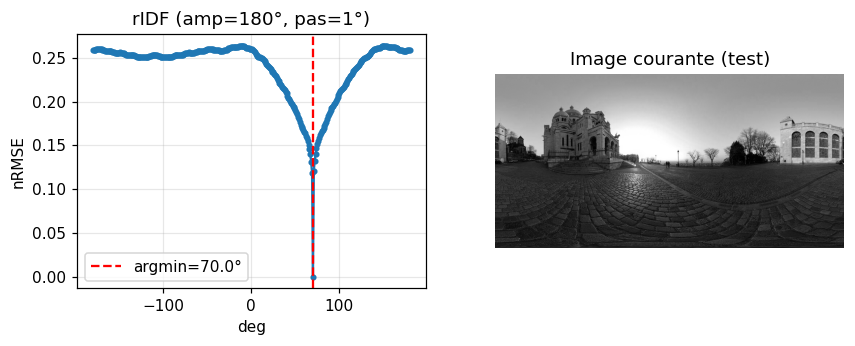

Argmin estimé: 70.0° (vrai: 70.0°)  |  erreur: 0.0°
Temps de calcul: 2.0s


In [ ]:

def preprocess(img, other, other2, other3):
    # TODO : preprocess the image
    return img_process

# Call and plot
rgb = read_img(ref_paths[0])
img_process = preprocess(rgb, colormode='blue')
ridf_argmin(img_process, rotation_initiale=70, amp_deg=180, step_deg=1)

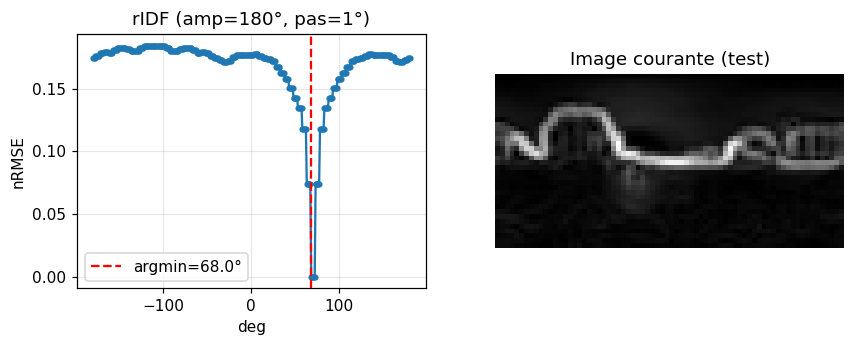

Argmin estimé: 68.0° (vrai: 70.0°)  |  erreur: 2.0°
Temps de calcul: 0.0s


In [ ]:
# TODO : Call and plots at least with 5 differents image process